<a href="https://colab.research.google.com/github/SWainty24/ATSC528/blob/main/03-Statistical_Objective_Analysis/statistical_oban.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [22]:
#Used Colab for further works, supports Pip
!pip install cartopy

In [23]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [24]:
### Read in observations ###
data_path = '/content/RAOBs_201903131200.txt'
data = np.genfromtxt(data_path, delimiter=',', dtype=str)

# Individual columns for each data
station_ids = data[:, 0]  # Station IDs
station_lat = data[:, 1].astype(float)  # Latitude values
station_lon = data[:, 2].astype(float)  # Longitude values
heights = data[:, 3].astype(float)  # 500-mb Height


In [25]:
phi0 = np.radians(60)  # central latitude φ0 in radians
lambda0 = np.radians(-115)
lat_rad=np.radians (station_lat)
lon_rad=np.radians(station_lon) # central longitude λ0 in radians
R = 6371*1000  # Earth's radius in meters
m = 1 / 15000000  # map scale

proj= ccrs.Stereographic(central_latitude=90, central_longitude=-115,true_scale_latitude=60)

Shape of x_grid: (22,)
Shape of y_grid: (28,)


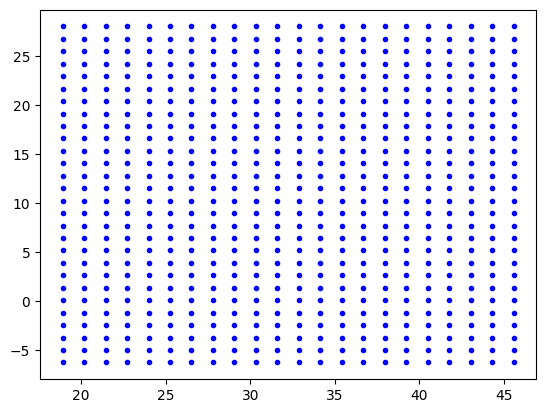

In [26]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0, y0 = 18.90, -6.30
dx, dy = 1.27, 1.27
nx, ny = 22,28
# Making a (22x28) grid
x_grid = np.linspace(x0, x0 + (nx - 1) * dx, nx)
y_grid = np.linspace(y0, y0 + (ny - 1) * dy, ny)

X, Y = np.meshgrid(x_grid, y_grid)
print("Shape of x_grid:", x_grid.shape)
print("Shape of y_grid:", y_grid.shape)
plt.scatter(X, Y, color='blue', label='Grid Points', marker='.')

obs_coords shape: (135, 2)


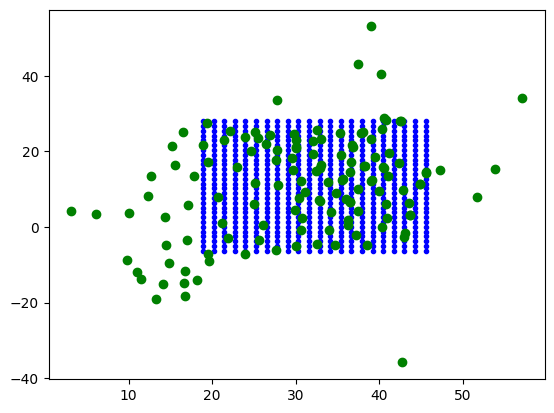

In [27]:
# Function to convert latitude and longitude to x, y in stereographic projection
def latlon_to_xy(station_lat, station_lon):

  lat_rad = np.radians(station_lat)
  lon_rad = np.radians(station_lon)

  sigma = (1+np.sin(phi0)) / (1+np.sin(lat_rad))

  x_obs = R * sigma * m *np.cos(lat_rad)*np.cos(np.radians(station_lon)-lambda0)*100

  y_obs = R * sigma * m *np.cos(lat_rad)*np.sin(np.radians(station_lon)-lambda0)*100



  return x_obs, y_obs

# Apply the function to all latitude and longitude values
obs_coords = np.array([latlon_to_xy(lat, lon) for lat, lon in zip(station_lat, station_lon)])

# Separate x and y coordinates
xk, yk = obs_coords[:, 0], obs_coords[:, 1]
# Check the shape of obs_coords
print(f"obs_coords shape: {obs_coords.shape}")

#Plot the Stations and the Grid to Verify Alignment (I got wrong here somewhere)
plt.scatter(X, Y, color='blue', label='Grid Points', marker='.')  # Plot the grid points
plt.scatter(xk, yk, color='green', label='Converted Station Positions', marker='o')  # Plot station positions

In [28]:
r_e=12.7775892;
Kd=10.8844524

In [32]:
def schlatter_correlation(s_squared, b_prime):
    """
    Computes the Schlatter correlation for given squared distances.
    """
    # Use np.where to handle array conditions
    return np.where(
        s_squared == 0,
        1.0,  # ρ(0) = 1
        0.95 * np.exp(-b_prime * s_squared)  # Correlation for s > 0
    )


In [33]:
def calculate_correlation_matrix(obs_coords, grid_coords, b_prime):
    """
    Computes the background error correlation matrices ρ_kl and ρ_ki.
    """
    # Compute squared distances between observation points (ρ_kl)
    distances_kl_squared = np.sum((obs_coords[:, None, :] - obs_coords[None, :, :])**2, axis=2)
    rho_kl = schlatter_correlation(distances_kl_squared, b_prime)

    # Compute squared distances between grid points and observation points (ρ_ki)
    distances_ki_squared = np.sum((grid_coords[:, None, :] - obs_coords[None, :, :])**2, axis=2)
    rho_ki = schlatter_correlation(distances_ki_squared, b_prime)

    return rho_kl, rho_ki

In [34]:
b = 1.24  # Range factor
b_prime = b * m**2  # Adjusted range factor for the grid

# Create the correlation matrices
grid_coords = np.column_stack((X.ravel(), Y.ravel()))  # Grid points as (x, y) pairs
obs_coords = np.column_stack((xk, yk))  # Observation points as (x, y) pairs

rho_kl, rho_ki = calculate_correlation_matrix(obs_coords, grid_coords, b_prime)


In [35]:
weights = []
for grid_x, grid_y in grid_coords:
    # Compute squared distances between grid point and observation points
    distances_ki_squared = np.sum((obs_coords - np.array([grid_x, grid_y]))**2, axis=1)
    rho_ki = schlatter_correlation(distances_ki_squared, b_prime)

    # Solve for weights: w_i = ρ^-1 * ρ_ki
    w_i = np.linalg.solve(rho_kl, rho_ki)
    weights.append(w_i)

weights = np.array(weights)

In [36]:
grid_coords = np.column_stack((X.ravel(), Y.ravel()))
rho_kl, rho_ki = calculate_correlation_matrix(obs_coords, grid_coords, b_prime)

# Precompute the inverse of the correlation matrix ρ_kl
rho_kl_inv = np.linalg.inv(rho_kl)

# Compute weights for all grid points
weights = rho_kl_inv @ rho_ki.T  # Matrix multiplication for all grid points

# Reshape weights for visualization
weights_grid = weights.T.reshape(X.shape + (len(xk),))  # Shape: (nx, ny, 135)

# Display one set of weights for a single grid point
weights_grid[0, 0]

array([0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740452,
       0.00740452, 0.00740452, 0.00740452, 0.00740452, 0.00740

In [39]:
grid_points = np.column_stack((X.ravel(), Y.ravel()))
grid_shape = X.shape  # Save grid shape for reshaping later
background_field = np.zeros(grid_points.shape[0])

for i, grid_point in enumerate(grid_points):
    grid_x, grid_y = grid_point  # Current grid point coordinates

    # Compute distances to observation points
    distances = np.sqrt((xk - grid_x)**2 + (yk - grid_y)**2)

    # Consider only observations within the radius of influence
    within_radius = distances < r_e
    if np.sum(within_radius) > 0:  # Check if there are observations within the radius
        # Create a temporary correlation vector ρ_ki with the correct dimension
        rho_ki = np.zeros(len(xk))
        rho_ki[within_radius] = schlatter_correlation(distances[within_radius]**2, b_prime)

        # Solve for weights using ρ_kl (precomputed) and current ρ_ki
        w_i = np.linalg.solve(rho_kl, rho_ki)
        values = heights[within_radius]

        # Compute the weighted average
        background_field[i] = np.sum(w_i[within_radius] * values) / np.sum(w_i[within_radius])
    else:
        background_field[i] = np.nan  # Mark as NaN if no points within radius

# Reshape the background field to grid shape
background_field = background_field.reshape(grid_shape)

In [43]:

def bilinear_interpolation(xk, yk, X, Y, values, RoI):
    interpolated_values = []

    for x, y in zip(xk, yk):
        # Locate indices of the grid points surrounding (x, y)
        x1_idx = np.searchsorted(X[0], x) - 1
        x2_idx = x1_idx + 1
        y1_idx = np.searchsorted(Y[:, 0], y) - 1
        y2_idx = y1_idx + 1

        # Ensure indices are within bounds of the grid
        if x1_idx < 0 or x2_idx >= X.shape[1] or y1_idx < 0 or y2_idx >= Y.shape[0]:
            dik = np.sqrt((x-X)**2 + (y-Y)**2)
            w = (RoI**2 - dik**2) / (RoI**2 + dik**2)
            w[dik>=RoI] = 0
            val = np.nansum(w*values)/np.nansum(w)
            interpolated_values.append(val)
            #interpolated_values.append(np.nan)  # Assign NaN if outside grid bounds
            continue

        # Retrieve the grid points and values for interpolation
        x1, x2 = X[0, x1_idx], X[0, x2_idx]
        y1, y2 = Y[y1_idx, 0], Y[y2_idx, 0]

        # Ensure f11, f21, f12, f22 are within the bounds
        f11 = values[y1_idx, x1_idx] if (y1_idx < values.shape[0] and x1_idx < values.shape[1]) else np.nan
        f21 = values[y1_idx, x2_idx] if (y1_idx < values.shape[0] and x2_idx < values.shape[1]) else np.nan
        f12 = values[y2_idx, x1_idx] if (y2_idx < values.shape[0] and x1_idx < values.shape[1]) else np.nan
        f22 = values[y2_idx, x2_idx] if (y2_idx < values.shape[0] and x2_idx < values.shape[1]) else np.nan

        # Calculate distances for interpolation
        dx = (x - x1) / (x2 - x1) if (x2 - x1) != 0 else 0
        dy = (y - y1) / (y2 - y1) if (y2 - y1) != 0 else 0

        # Perform bilinear interpolation, handling any NaN values
        interpolated_value = (1 - dx) * (1 - dy) * f11 + dx * (1 - dy) * f21 + \
                             (1 - dx) * dy * f12 + dx * dy * f22
        interpolated_values.append(interpolated_value)

    return np.array(interpolated_values)
interpolated_values = bilinear_interpolation(xk, yk, X, Y, background_field, r_e)

<ipython-input-43-fe170e3b9a24>:16: RuntimeWarning: invalid value encountered in scalar divide
  val = np.nansum(w*values)/np.nansum(w)


In [46]:
# Function to compute analysis field for N closest stations
def compute_analysis_field(N, X, Y, xk, yk, f_O, f_B_obs, f_B_grid):
    f_A_grid = np.zeros(X.shape)  # Initialize analysis field

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Get the current grid point
            grid_x, grid_y = X[i, j], Y[i, j]

            # Compute distances from grid point to observation points
            distances = np.sqrt((xk - grid_x)**2 + (yk - grid_y)**2)

            # Get the indices of the N closest stations
            closest_indices = np.argsort(distances)[:N]

            # Extract weights, observation values, and background values for the closest stations
            rho_kl_inv_closest = np.linalg.inv(rho_kl[np.ix_(closest_indices, closest_indices)])
            rho_ki_closest = schlatter_correlation(distances[closest_indices]**2, b_prime)
            weights_closest = rho_kl_inv_closest @ rho_ki_closest

            f_O_closest = f_O[closest_indices]
            f_B_obs_closest = f_B_obs[closest_indices]

            # Compute the analysis value
            f_A_grid[i, j] = f_B_grid[i, j] + np.sum(
                weights_closest * (f_O_closest - f_B_obs_closest)
            )

    return f_A_grid

In [48]:
Analysis_N2 = compute_analysis_field(2, X, Y, xk, yk, heights, interpolated_values, background_field)
Analysis_N4 = compute_analysis_field(4, X, Y, xk, yk, heights, interpolated_values, background_field)
Analysis_N10 = compute_analysis_field(10, X, Y, xk, yk, heights, interpolated_values, background_field)

In [49]:
X_meters = X * 0.01 # Convert cm to meters

Y_meters = Y * 0.01 # Convert cm to meters



# grid x-y coordinates back to latitude and longitude

x_squared_y_squared = (X_meters/m)**2 + (Y_meters/m)**2

lambda_grid = lambda0 + np.arctan(Y_meters/X_meters)

phi_grid = (np.pi/2) - 2*np.arctan((x_squared_y_squared**0.5)/(R*(1+np.sin(phi0))))



# Convert to degrees

latitude_grid = np.degrees(phi_grid)

longitude_grid = np.degrees(lambda_grid)

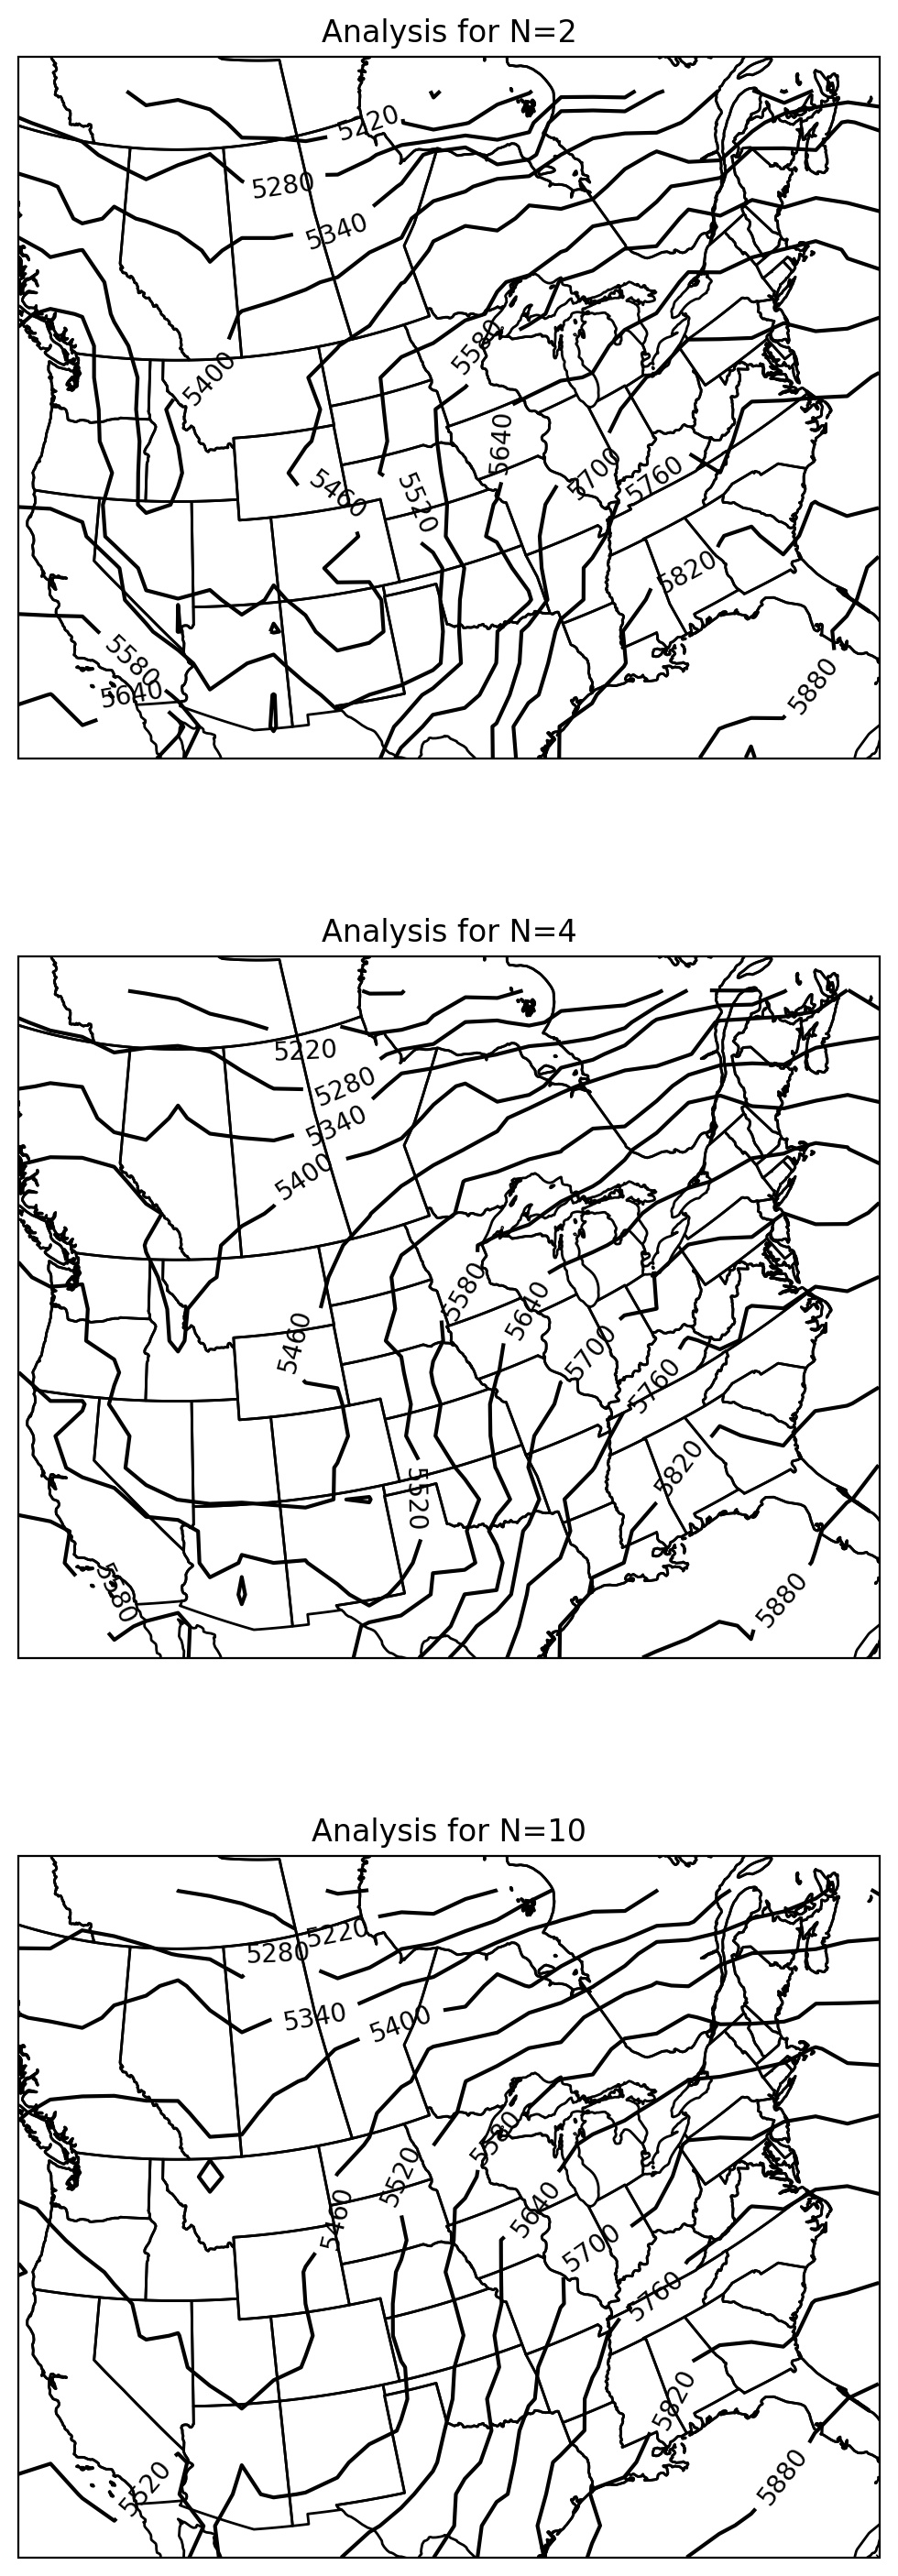

In [77]:
### Plot 500mb analyses over a map ###
#convert x,y to lat/long

LAT = latitude_grid  # Replace with your latitude grid array
LON = longitude_grid  # Replace with your longitude grid array

ANALYSIS = [Analysis_N2, Analysis_N4, Analysis_N10]  # Replace with your analysis results

proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude=60)
fig = plt.figure(figsize=(5, 15), dpi=200)

titles = ["Analysis for N=2", "Analysis for N=4", "Analysis for N=10"]

for i in range(3):
    ax1 = fig.add_subplot(3, 1, i + 1, projection=proj)
    ax1.add_feature(cfeature.STATES)
    ax1.add_feature(cfeature.COASTLINE)
    cs1 = ax1.contour(
        LON,
        LAT,
        ANALYSIS[i],
        colors="k",
        levels=np.arange(0, 8000, 60),
        transform=ccrs.PlateCarree(),
    )
    plt.clabel(cs1, levels=np.arange(0, 8000, 60))
    ax1.set_title(titles[i], fontsize=12)  # Add titles for each subplot

fig.tight_layout()
plt.show()



In [58]:
interpolated_valuesN2 = bilinear_interpolation(xk, yk, X, Y, Analysis_N2, r_e)
rmse1 = np.sqrt(np.nansum((heights - interpolated_valuesN2)**2)/sum(~np.isnan(interpolated_valuesN2)))
print("RMSE_1:",rmse1)

58.233613984599046


<ipython-input-43-fe170e3b9a24>:16: RuntimeWarning: invalid value encountered in scalar divide
  val = np.nansum(w*values)/np.nansum(w)


In [57]:
interpolated_valuesN4 = bilinear_interpolation(xk, yk, X, Y, Analysis_N4, r_e)
rmse2 = np.sqrt(np.nansum((heights - interpolated_valuesN4)**2)/sum(~np.isnan(interpolated_valuesN4)))
print("RMSE_2:",rmse2)

59.03718857952131


<ipython-input-43-fe170e3b9a24>:16: RuntimeWarning: invalid value encountered in scalar divide
  val = np.nansum(w*values)/np.nansum(w)


In [59]:
interpolated_valuesN10 = bilinear_interpolation(xk, yk, X, Y, Analysis_N10, r_e)
rmse3 = np.sqrt(np.nansum((heights - interpolated_valuesN10)**2)/sum(~np.isnan(interpolated_valuesN10)))
print("RMSE_3:",rmse3)

63.79220035088265


<ipython-input-43-fe170e3b9a24>:16: RuntimeWarning: invalid value encountered in scalar divide
  val = np.nansum(w*values)/np.nansum(w)


In [73]:
Increment_N2 = background_field - Analysis_N2
Increment_N4= background_field - Analysis_N4
Increment_N10 = background_field - Analysis_N10

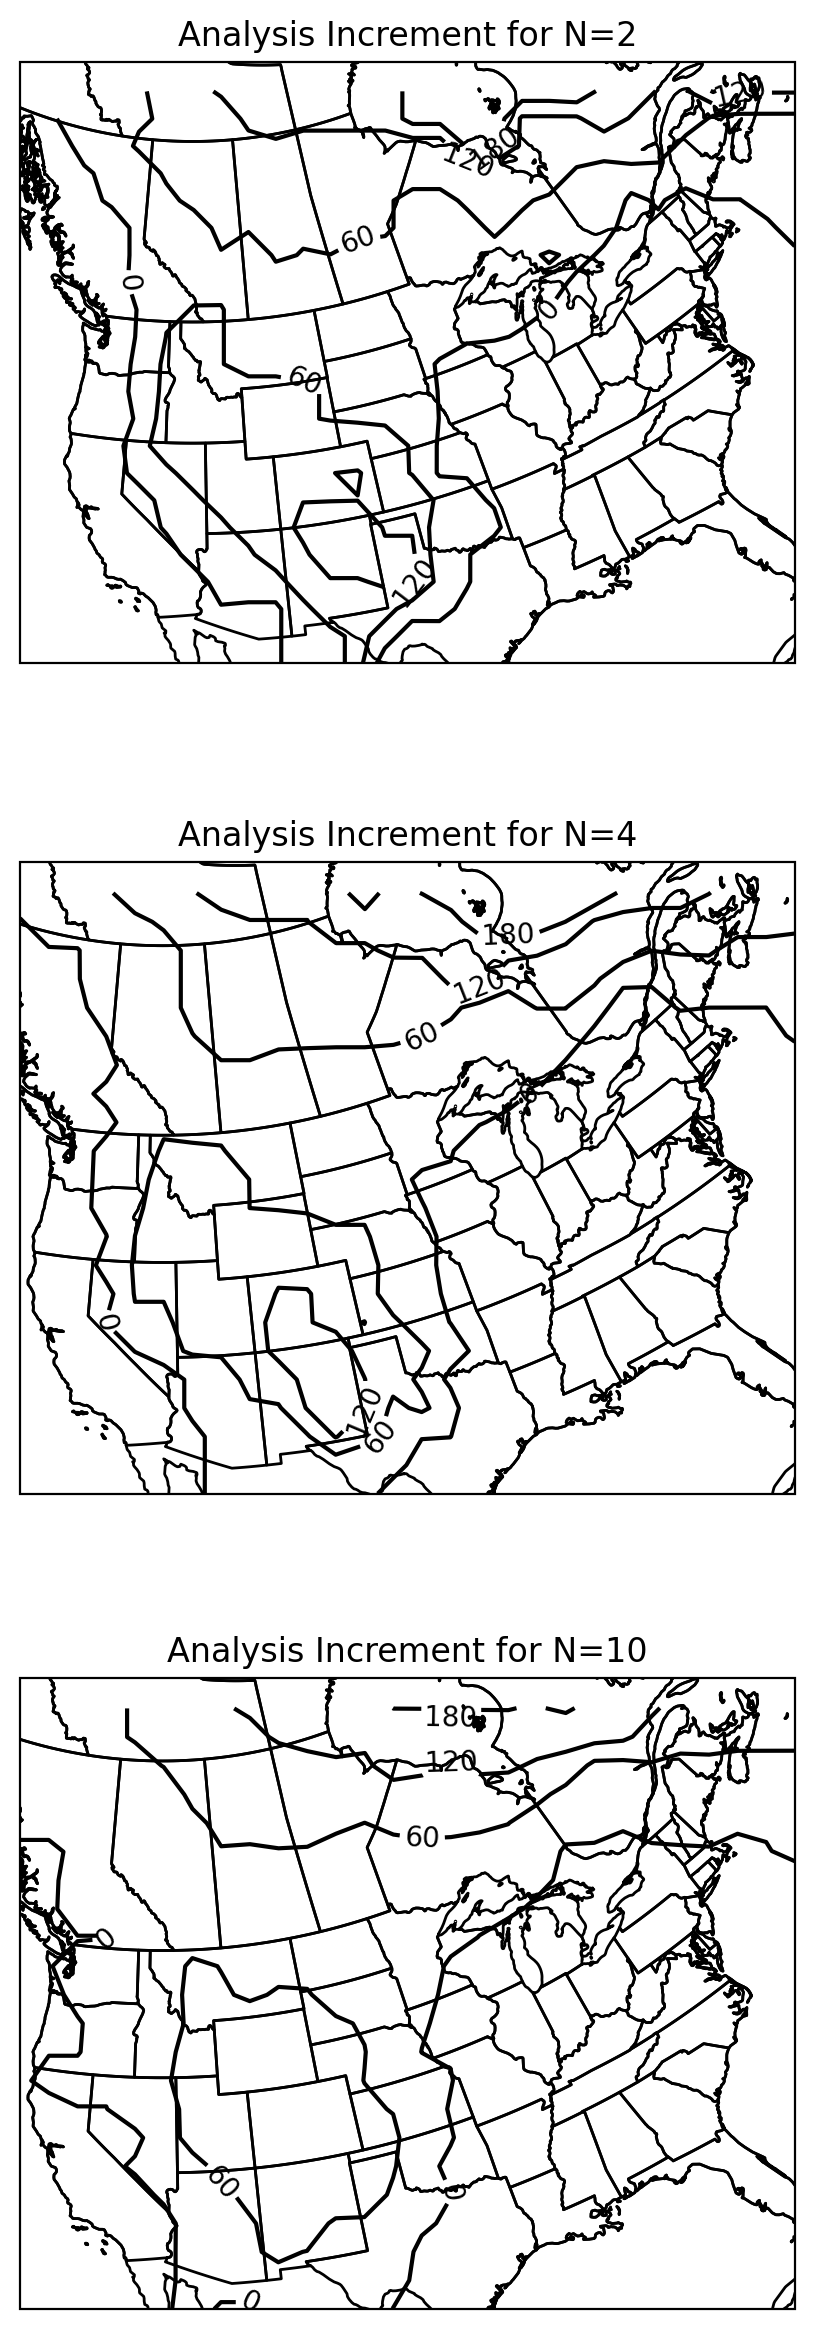

In [79]:
# Set up the figure and subplots with the specified projection
LAT = latitude_grid  # Replace with your latitude grid array
LON = longitude_grid  # Replace with your longitude grid array

proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude=60)
fig = plt.figure(figsize=(5, 15), dpi=200)
ANALYSIS=[Increment_N2,Increment_N4,Increment_N10]


titles = ["Analysis Increment for N=2", "Analysis Increment for N=4", "Analysis Increment for N=10"]

for i in range(3):
    ax1 = fig.add_subplot(3, 1, i + 1, projection=proj)
    ax1.add_feature(cfeature.STATES)
    ax1.add_feature(cfeature.COASTLINE)
    cs1 = ax1.contour(
        LON,
        LAT,
        ANALYSIS[i],
        colors="k",
        levels=np.arange(0, 8000, 60),
        transform=ccrs.PlateCarree(),
    )
    plt.clabel(cs1, levels=np.arange(0, 8000, 60))
    ax1.set_title(titles[i], fontsize=12)  # Add titles for each subplot




In [80]:
diffN2 =interpolated_valuesN2 - heights
diffN4 =interpolated_valuesN4 - heights
diffN10 =interpolated_valuesN10 - heights

In [81]:
### Store the number of observations available for each grid point in text files ###
np.savetxt("Analysis_N2.txt", Analysis_N2, fmt="%.6f", header="Analysis Heights for N=2")
np.savetxt("Analysis_N4.txt", Analysis_N4, fmt="%.6f", header="Analysis Heights for N=4")
np.savetxt("Analysis_N10.txt", Analysis_N10, fmt="%.6f", header="Analysis Heights for N=10")

np.savetxt("Diff_N2.txt", diffN2, fmt="%.6f", header="InterpolatedAnalysis2-heights")
np.savetxt("Diff_N4.txt", diffN4, fmt="%.6f", header="InterpolatedAnalysis4-heights")
np.savetxt("Diff_N10.txt", diffN10, fmt="%.6f", header="InterpolatedAnalysis10-heights")


np.savetxt("IncrementN2.txt", Increment_N2, fmt="%.6f", header="Background-AnalysisN2")
np.savetxt("IncrementN4.txt", Increment_N4, fmt="%.6f", header="Background-AnalysisN4")
np.savetxt("IncrementN10.txt", Increment_N10, fmt="%.6f", header="Background-AnalysisN10")

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.


2 - Describe the differences that you see in your contoured analyses.
    Does one analysis seem to be smoother than the other?  If so, what would cause this?


3 - What happens as you increase the number of points considered for the analysis?  Is this
    desirable?  Why or why not?

'''